In [405]:
#!pip uninstall torch
!pip install torch==1.0.0
import torch
from torch.utils.data import DataLoader, Dataset

import torchgeometry as tgm
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (30,10)

import cv2
from PIL import Image, ImageSequence

from landmarks import detect_landmark
from perspective_projection_matrix import get_perspective, get_P
from pinhole_camera_model import facial_landmarks
from morphable_model import read_pca_model, get_face_point_cloud
from viewport_matrix import get_V

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
#dataset with faces
class Faces(Dataset):
        def __init__(self, file = 'faces_sparser_sampling.gif', data_size= 30):
            im = Image.open('faces_sparser_sampling.gif')
            frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(im)])
            self.data = frames[:data_size]
            self.target = [torch.from_numpy(detect_landmark(img)).to(dtype = torch.float) for img in self.data]
            
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            return (self.data[idx], self.target[idx])
batch_size=10
dataset = Faces()
dataloader = DataLoader(dataset,  batch_size = batch_size, shuffle = True, num_workers = 0, drop_last = True)


In [523]:
#rewritten to torch functions 
def get_face_point_cloud_torch(p, alpha, delta): 
    """
    Get face point cloud for given alpha and delta.

    :param p: PCA model received with read_pca_model()
    :param alpha: size 30
    :param delta: size 20
    :return: 3D point cloud of size [num_points x 3]
    """
    G_id = torch.from_numpy(p["mu_id"]) + torch.from_numpy(p["E_id"]) @ ( torch.from_numpy(p["sigma_id"]) * alpha)
    G_ex = torch.from_numpy(p["mu_ex"]) + torch.from_numpy(p["E_ex"]) @ ( torch.from_numpy(p["sigma_ex"]) * delta)
    return (G_id+G_ex).view((-1, 3))






def rotation_matrix(w):

    theta1, theta2, theta3 = w[0], w[1], w[2]
    
    zero = theta1.detach()*0
    one = zero.clone()+1
    
    cosx, sinx, cosy, siny, cosz, sinz = theta1.cos(), theta1.sin(), theta2.cos(), theta2.sin(), theta3.cos(),  theta3.sin()
    
    r_x = torch.stack([one, zero, zero,
                        zero,  cosx, sinx,
                        zero,  -sinx,  cosx]).view( 3, 3)
    
    r_y = torch.stack([cosy, zero,  -siny,
                        zero,  one, zero,
                        siny, zero,  cosy]).view( 3, 3)
    
    r_z = torch.stack([cosz, -sinz, zero,
                        sinz,  cosz, zero,
                        zero, zero,  one]).view( 3, 3)


    R = r_x @ r_y @ r_z
    return R


def facial_landmarks_torch(alpha, delta, w, t):
    """
    Construct facial landmarks from facial geometry latent parameters alpha, delta and object transformation w, t.

    :param alpha: array, 30dim
    :param delta: array, 20dim
    :param w: rotation angles around x,y, z. Given as list [theta_x, theta_y, theta_z].
    :param t: translation in x,y,z space. Given as list [translation_x, translation_y, translation_z]
    :return:
    """
    landmarks_idx = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)

    pca = read_pca_model()
    G = get_face_point_cloud_torch(pca, alpha, delta)[landmarks_idx].t()
    G_h = [G , torch.ones(G.shape[1]).view((1, -1))]
    G_h = torch.cat(G_h, dim=0)
    
    # get T matrix
    T = torch.eye(4)
    T[:3, :3] = rotation_matrix(w)#rotation_tensor(w, 1)#get_rotation_matrix_torch(w)  #torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])#
    T[:3, 3] = t
    
    # Get V and P matrices
    W = 172
    H = 162

    image_aspect_ratio = W / H
    angle = 10
    near = .1
    far = 10

    right, left, top, bottom = get_perspective(image_aspect_ratio, angle, near, far)
    
    V = get_V(right, left, top, bottom)

    P = get_P(near, far, right, left, top, bottom)
    [V, P] = list(map(torch.from_numpy, [V, P]))
    V,P = V.to(dtype = torch.float32), P.to(dtype = torch.float32)
    n,f, t, b = near, far, top, bottom
    P = torch.Tensor([[(2 * n) / (t-b), 0, 0, 0],
                [0, (2 * n) / (t - b), 0, 0],
              [0, 0, -(f + n) / (f - n), -(2 * f * n) / (f - n)],
              [0, 0, -1, 0]])
    i =  V @ P @ T @ G_h

    # homo to cartesian
    i = i/i[3,:].clone()

    # two-dimensional
    return i[:2, :].t()



def normalise(landmarks, is_ground = False, values =None):
    
    max_x = torch.max(landmarks[:,0].detach())
    max_y = torch.max(landmarks[:,1].detach())
    min_x = torch.min(landmarks[:,0].detach())
    min_y = torch.min(landmarks[:,1].detach())

    
    scale=torch.sqrt((max_x-min_x).pow(2) + (max_y-min_y).pow(2))
    
    if values!=None:
        length, min_x, min_y = values
    landmarks[:,0] = (landmarks[:,0] - min_x)/scale 
    landmarks[:,1] = (landmarks[:,1] - min_y)/scale
    if is_ground:
        return landmarks, [scale, min_x, min_y]
    return landmarks



def denormalise(estimated_landmarks, target_landmarks, is_numpy = True):
    if is_numpy:
        estimated_landmarks, target_landmarks = torch.from_numpy(estimated_landmarks) ,  torch.form_numpy(target_landmarks)
    landmarks, values = normalise(target_landmarks, is_ground = True)
    
    estimated_landmarks = normalise(estimated_landmarks)
    estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
    estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
    estimated_landmarks = estimated_landmarks.detach().numpy()
    
    return estimated_landmarks
    

0 0.3070904612541199
20 0.2979242503643036
40 0.2648986577987671
60 0.2464572787284851
80 0.2336956411600113
99 0.22334584593772888
100 0.22286954522132874
120 0.21507692337036133
140 0.21019384264945984
160 0.20589813590049744
180 0.19903889298439026
200 0.19456787407398224
220 0.19212856888771057
240 0.19142568111419678
260 0.19219312071800232
280 0.19420474767684937
300 0.19726690649986267
320 0.20121833682060242
340 0.20166312158107758
360 0.2021242082118988
380 0.20259948074817657
torch.Size([68, 2])


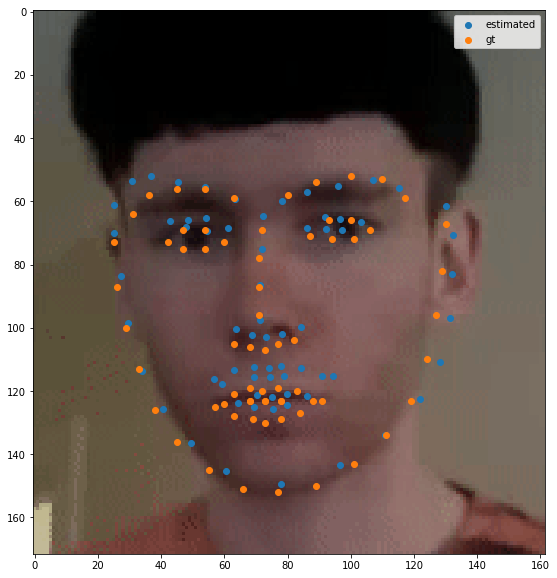

In [546]:
#initialise variables to optimise
alpha = Variable(torch.zeros(30), requires_grad=True)
delta = Variable(torch.zeros(20), requires_grad=True)
w = Variable(torch.tensor([np.pi, 0.0, 0.0]), requires_grad=True)
t = Variable(torch.tensor([0.0,0.0,-400.0]), requires_grad=True)
#read an image
image = cv2.imread('in.png')#
img =  dataset[0][0]#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)##
#get ground truth landmarks
target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
target, values = normalise(target, is_ground=True)
#set optimisation parameters
lr = .001
opt = torch.optim.Adam([alpha, delta, w, t], lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1)
lambda_alpha = 1e-3
lambda_delta = 1e-3
#iterate
for i in range(400):
    
    if i == 150 or i==320:
        scheduler.step()
        
    
    opt.zero_grad()
    #get predicted landmarks
    prediction_landmarks = facial_landmarks_torch(alpha, delta, w, t)
    prediction_landmarks = normalise(prediction_landmarks)
    
    #compute loss
    loss_lan = torch.sum(torch.norm((prediction_landmarks - target)).pow(2))
    loss_reg = lambda_alpha * (alpha.pow(2)).sum() + lambda_delta * (delta.pow(2)).sum()
    loss = loss_lan + loss_reg
    #backprop
    if i%20==0 or i ==99:
        print(i, loss.item())
    loss.backward()
    opt.step()
#compute final landmarks


target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
print(target.shape)
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(img)
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()

In [541]:
alpha[:20]==delta

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8)

In [500]:
np.save("best_params.npy", np.array([alpha_m, delta_m, w_m, t_m]))

0 0 0.4609108865261078
0 1 0.3024821877479553
0 2 0.23146367073059082
1 0 0.23418958485126495
1 1 0.2530532479286194
1 2 0.2590029835700989
2 0 0.24918529391288757
2 1 0.2482558786869049
2 2 0.2603113055229187
3 0 0.25322291254997253
3 1 0.25606948137283325
3 2 0.24759885668754578
4 0 0.261171817779541
4 1 0.2538558840751648
4 2 0.24166814982891083
5 0 0.2454008311033249
5 1 0.2490319460630417
5 2 0.26223069429397583
6 0 0.2470811903476715
6 1 0.24243135750293732
6 2 0.2671477198600769
7 0 0.24769313633441925
7 1 0.2487107813358307
7 2 0.2602565884590149
8 0 0.26191246509552
8 1 0.24087996780872345
8 2 0.2538679540157318
9 0 0.24740585684776306
9 1 0.25874486565589905
9 2 0.25050967931747437


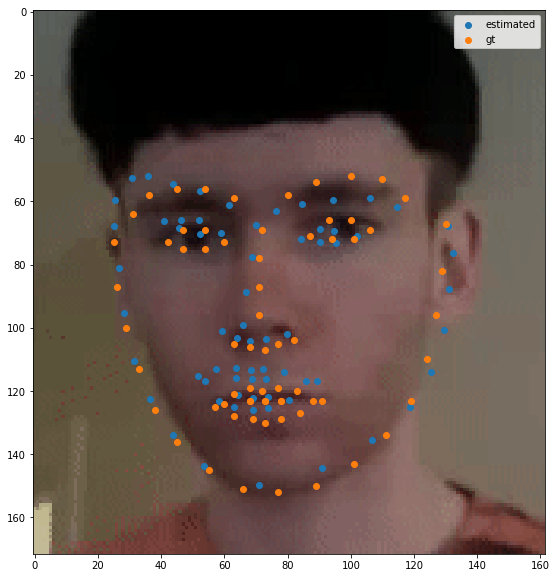

In [498]:
#optimisation of multiple frames
#initialise variables to optimise
alpha = Variable(torch.zeros(30), requires_grad=True)
delta = Variable(torch.zeros(20), requires_grad=True)
w = Variable(torch.tensor([np.pi, 0.0, 0.0]), requires_grad=True)
t = Variable(torch.tensor([0.0,0.0,-400.0]), requires_grad=True)

#set optimisation parameters
lr = .1
opt = torch.optim.Adam([alpha, delta, w, t], lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1)
lambda_alpha = 1e-2
lambda_delta = 1e-2
#iterate
epoch = 0
while epoch<10:
    for i, (image_batch, target_batch) in enumerate(dataloader):
       
        if i % 100 == 0:
            scheduler.step()
            
        
        opt.zero_grad()
        
        loss_tensor = torch.ones(batch_size)
        
        for j, target in enumerate(target_batch):
            #get predicted landmarks
            target, values = normalise(target, is_ground=True)
            prediction_landmarks = facial_landmarks_torch(alpha, delta, w, t)
            prediction_landmarks = normalise(prediction_landmarks)
        
            
            #compute loss
            loss_lan = torch.sum(torch.norm((prediction_landmarks - target)).pow(2))
            loss_reg = lambda_alpha * (alpha.pow(2)).sum() + lambda_delta * (delta.pow(2)).sum()
            loss = loss_lan + loss_reg
            loss_tensor[j] = loss
            #backprop
        mean_loss = torch.mean(loss_tensor)
        
        print(epoch, i, mean_loss.item())
        mean_loss.backward()
        opt.step()
    
    epoch+=1
    #compute final landmarks


#target = torch.from_numpy(detect_landmark(dataset[0][0])).to(dtype = torch.float)
target = dataset[0][1]
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(dataset[0][0])
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()

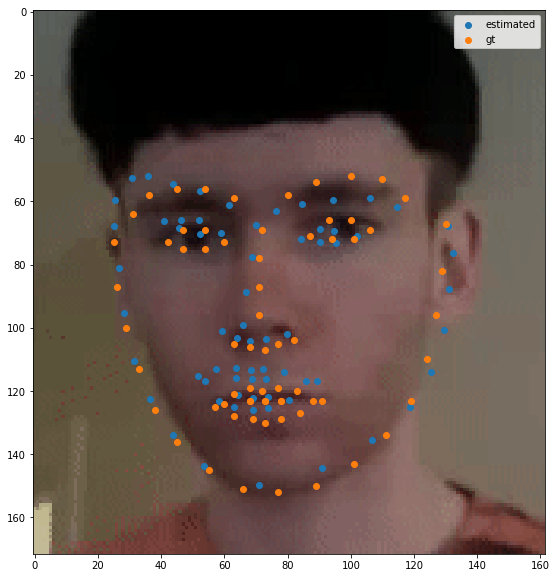

In [499]:
target = dataset[0][1]
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(dataset[0][0])
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()
alpha_m, delta_m, w_m, t_m = alpha, delta, w, t